##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/official_models/tutorials/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

In this example, we will work through fine-tuning a BERT model using the tensorflow-models PIP package.

The pretrained BERT model this tutorial is based on is also available on [TensorFlow Hub](https://tensorflow.org/hub), to see how to use it refer to the [Hub Appendix](#hub_bert)

## Setup

### Install the TensorFlow Model Garden pip package

*  `tf-models-official` is the stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo. To include latest changes, you may install `tf-models-nightly`,
which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [2]:
!pip install -q tf-models-official==2.4.0

### Imports

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


### Resources

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from [TensorFlow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2):

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

## The data
For this example we used the [GLUE MRPC dataset from TFDS](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up so that it can be directly fed into the BERT model, so this section also handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

*   Number of labels: 2.
*   Size of training dataset: 3668.
*   Size of evaluation dataset: 408.
*   Maximum sequence length of training and evaluation dataset: 128.


In [6]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

In [7]:
list(glue.keys())

['test', 'train', 'validation']

The `info` object describes the dataset and it's features:

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

The two classes are:

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


### The BERT tokenizer

To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a `keras.layer` like you can with `preprocessing.TextVectorization`.

The following code rebuilds the tokenizer that was used by the base model:

In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenize a sentence:

In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Preprocess the data

The section manually preprocessed the dataset into the format expected by the model.

This dataset is small, so preprocessing can be done quickly and easily in memory. For larger datasets the `tf_models` library includes some tools for preprocessing and re-serializing a dataset. See [Appendix: Re-encoding a large dataset](#re_encoding_tools) for details.

#### Encode the sentences

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [15]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

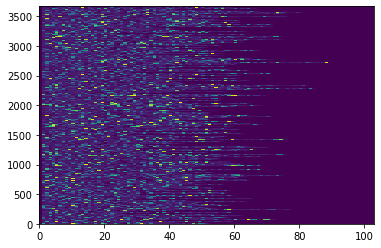

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

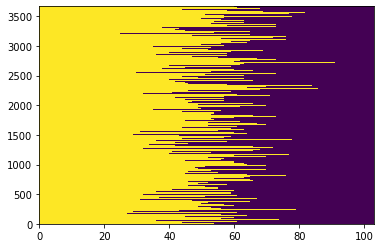

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of. 

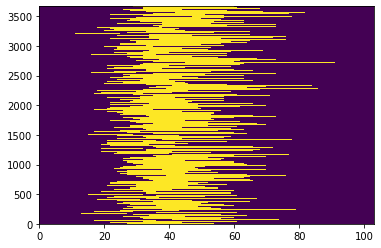

In [18]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the `glue/mrpc` dataset.

In [19]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [20]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [21]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## The model

### Build the model


The first step is to download the configuration  for the pre-trained model.


In [22]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [23]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

The classifier has three inputs and one output:

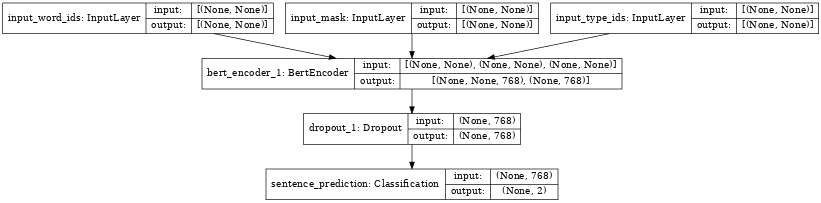

In [24]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [25]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.3999117 ,  0.19228943],
       [-0.48039404,  0.49550664],
       [-0.4205317 ,  0.4514861 ],
       [-0.46268317,  0.24971014],
       [-0.24856849,  0.29781285],
       [-0.20492092,  0.33435237],
       [-0.16171221,  0.12575442],
       [-0.17115599,  0.40965632],
       [-0.23386969,  0.41947454],
       [-0.5728958 ,  0.40995434]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

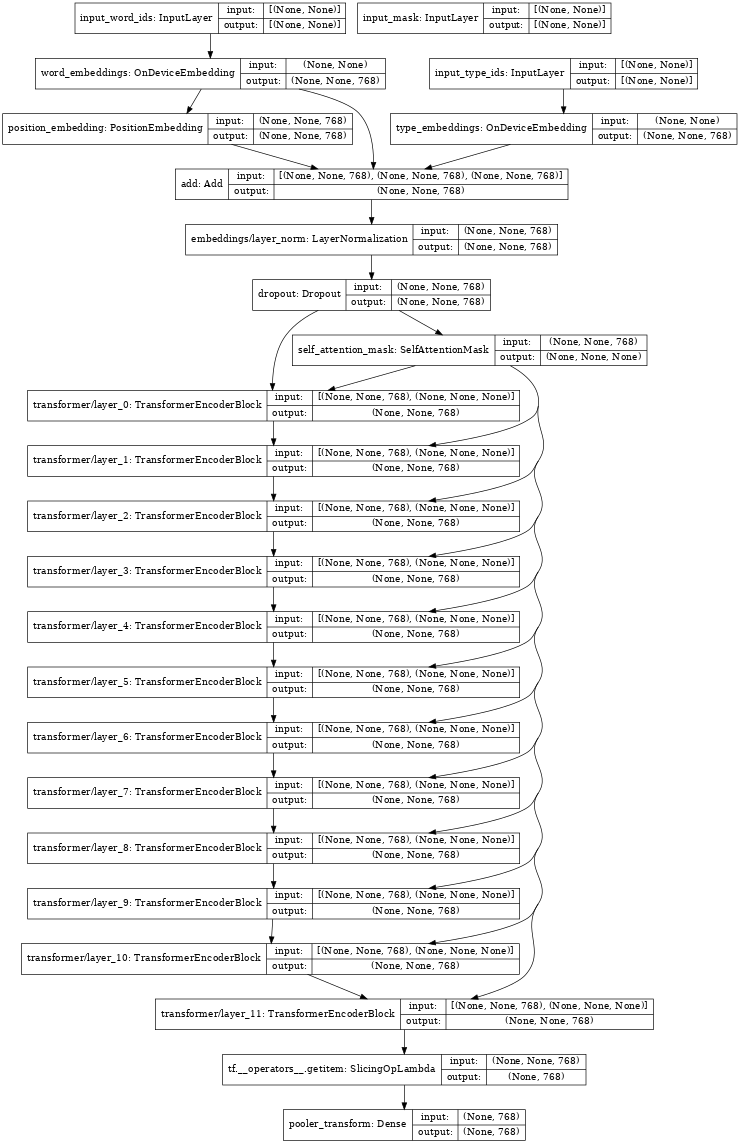

In [26]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [27]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [28]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [29]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

To see an example of how to customize the optimizer and it's schedule, see the [Optimizer schedule appendix](#optiizer_schedule).

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [30]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3


  1/115 [..............................] - ETA: 23:30 - loss: 0.6495 - accuracy: 0.6875

  2/115 [..............................] - ETA: 23s - loss: 0.6466 - accuracy: 0.6797  

  3/115 [..............................] - ETA: 23s - loss: 0.6444 - accuracy: 0.6788

  4/115 [>.............................] - ETA: 23s - loss: 0.6425 - accuracy: 0.6790

  5/115 [>.............................] - ETA: 23s - loss: 0.6425 - accuracy: 0.6745

  6/115 [>.............................] - ETA: 22s - loss: 0.6425 - accuracy: 0.6714

  7/115 [>.............................] - ETA: 22s - loss: 0.6434 - accuracy: 0.6674

  8/115 [=>............................] - ETA: 22s - loss: 0.6433 - accuracy: 0.6660

  9/115 [=>............................] - ETA: 22s - loss: 0.6437 - accuracy: 0.6645

 10/115 [=>............................] - ETA: 22s - loss: 0.6445 - accuracy: 0.6624

 11/115 [=>............................] - ETA: 21s - loss: 0.6448 - accuracy: 0.6611

 12/115 [==>...........................] - ETA: 21s - loss: 0.6450 - accuracy: 0.6600

 13/115 [==>...........................] - ETA: 21s - loss: 0.6450 - accuracy: 0.6594

 14/115 [==>...........................] - ETA: 21s - loss: 0.6448 - accuracy: 0.6593

 15/115 [==>...........................] - ETA: 20s - loss: 0.6445 - accuracy: 0.6594

 16/115 [===>..........................] - ETA: 20s - loss: 0.6441 - accuracy: 0.6597

 17/115 [===>..........................] - ETA: 20s - loss: 0.6433 - accuracy: 0.6606

 18/115 [===>..........................] - ETA: 20s - loss: 0.6431 - accuracy: 0.6609

 19/115 [===>..........................] - ETA: 20s - loss: 0.6427 - accuracy: 0.6613

 20/115 [====>.........................] - ETA: 19s - loss: 0.6424 - accuracy: 0.6616

 21/115 [====>.........................] - ETA: 19s - loss: 0.6419 - accuracy: 0.6622

 22/115 [====>.........................] - ETA: 19s - loss: 0.6413 - accuracy: 0.6630

 23/115 [=====>........................] - ETA: 19s - loss: 0.6407 - accuracy: 0.6637

 24/115 [=====>........................] - ETA: 19s - loss: 0.6402 - accuracy: 0.6643

 25/115 [=====>........................] - ETA: 18s - loss: 0.6398 - accuracy: 0.6648

 26/115 [=====>........................] - ETA: 18s - loss: 0.6392 - accuracy: 0.6655

 27/115 [======>.......................] - ETA: 18s - loss: 0.6388 - accuracy: 0.6660

 28/115 [======>.......................] - ETA: 18s - loss: 0.6384 - accuracy: 0.6665

 29/115 [======>.......................] - ETA: 18s - loss: 0.6381 - accuracy: 0.6668

 30/115 [======>.......................] - ETA: 17s - loss: 0.6378 - accuracy: 0.6673

 31/115 [=======>......................] - ETA: 17s - loss: 0.6375 - accuracy: 0.6677

 32/115 [=======>......................] - ETA: 17s - loss: 0.6374 - accuracy: 0.6678

 33/115 [=======>......................] - ETA: 17s - loss: 0.6373 - accuracy: 0.6680

 34/115 [=======>......................] - ETA: 16s - loss: 0.6372 - accuracy: 0.6683

 35/115 [========>.....................] - ETA: 16s - loss: 0.6371 - accuracy: 0.6684

 36/115 [========>.....................] - ETA: 16s - loss: 0.6371 - accuracy: 0.6685

 37/115 [========>.....................] - ETA: 16s - loss: 0.6371 - accuracy: 0.6685

 38/115 [========>.....................] - ETA: 16s - loss: 0.6370 - accuracy: 0.6686

 39/115 [=========>....................] - ETA: 15s - loss: 0.6369 - accuracy: 0.6688

 40/115 [=========>....................] - ETA: 15s - loss: 0.6368 - accuracy: 0.6689

 41/115 [=========>....................] - ETA: 15s - loss: 0.6367 - accuracy: 0.6690

 42/115 [=========>....................] - ETA: 15s - loss: 0.6366 - accuracy: 0.6690

 43/115 [==========>...................] - ETA: 15s - loss: 0.6365 - accuracy: 0.6691

 44/115 [==========>...................] - ETA: 14s - loss: 0.6364 - accuracy: 0.6691

 45/115 [==========>...................] - ETA: 14s - loss: 0.6364 - accuracy: 0.6691

 46/115 [===========>..................] - ETA: 14s - loss: 0.6363 - accuracy: 0.6692

 47/115 [===========>..................] - ETA: 14s - loss: 0.6362 - accuracy: 0.6692

 48/115 [===========>..................] - ETA: 14s - loss: 0.6361 - accuracy: 0.6693

 49/115 [===========>..................] - ETA: 13s - loss: 0.6359 - accuracy: 0.6694

 50/115 [============>.................] - ETA: 13s - loss: 0.6358 - accuracy: 0.6696

 51/115 [============>.................] - ETA: 13s - loss: 0.6356 - accuracy: 0.6698

 52/115 [============>.................] - ETA: 13s - loss: 0.6354 - accuracy: 0.6700

 53/115 [============>.................] - ETA: 12s - loss: 0.6351 - accuracy: 0.6702

 54/115 [=============>................] - ETA: 12s - loss: 0.6349 - accuracy: 0.6705

 55/115 [=============>................] - ETA: 12s - loss: 0.6346 - accuracy: 0.6707

 56/115 [=============>................] - ETA: 12s - loss: 0.6344 - accuracy: 0.6709

 57/115 [=============>................] - ETA: 12s - loss: 0.6341 - accuracy: 0.6711

 58/115 [==============>...............] - ETA: 11s - loss: 0.6339 - accuracy: 0.6713

 59/115 [==============>...............] - ETA: 11s - loss: 0.6337 - accuracy: 0.6714

 60/115 [==============>...............] - ETA: 11s - loss: 0.6335 - accuracy: 0.6716

 61/115 [==============>...............] - ETA: 11s - loss: 0.6333 - accuracy: 0.6717

 62/115 [===============>..............] - ETA: 11s - loss: 0.6330 - accuracy: 0.6719

 63/115 [===============>..............] - ETA: 10s - loss: 0.6328 - accuracy: 0.6722

 64/115 [===============>..............] - ETA: 10s - loss: 0.6325 - accuracy: 0.6724

 65/115 [===============>..............] - ETA: 10s - loss: 0.6323 - accuracy: 0.6726

 66/115 [================>.............] - ETA: 10s - loss: 0.6320 - accuracy: 0.6728

 67/115 [================>.............] - ETA: 10s - loss: 0.6317 - accuracy: 0.6731

 68/115 [================>.............] - ETA: 9s - loss: 0.6315 - accuracy: 0.6733 

 69/115 [=================>............] - ETA: 9s - loss: 0.6312 - accuracy: 0.6735

 70/115 [=================>............] - ETA: 9s - loss: 0.6309 - accuracy: 0.6738

 71/115 [=================>............] - ETA: 9s - loss: 0.6307 - accuracy: 0.6740

 72/115 [=================>............] - ETA: 9s - loss: 0.6304 - accuracy: 0.6743

 73/115 [==================>...........] - ETA: 8s - loss: 0.6301 - accuracy: 0.6745

 74/115 [==================>...........] - ETA: 8s - loss: 0.6298 - accuracy: 0.6748

 75/115 [==================>...........] - ETA: 8s - loss: 0.6295 - accuracy: 0.6750

 76/115 [==================>...........] - ETA: 8s - loss: 0.6293 - accuracy: 0.6752

 77/115 [===================>..........] - ETA: 7s - loss: 0.6290 - accuracy: 0.6755

 78/115 [===================>..........] - ETA: 7s - loss: 0.6288 - accuracy: 0.6757

 79/115 [===================>..........] - ETA: 7s - loss: 0.6285 - accuracy: 0.6759

 80/115 [===================>..........] - ETA: 7s - loss: 0.6282 - accuracy: 0.6761

 81/115 [====================>.........] - ETA: 7s - loss: 0.6279 - accuracy: 0.6763

 82/115 [====================>.........] - ETA: 6s - loss: 0.6277 - accuracy: 0.6766

 83/115 [====================>.........] - ETA: 6s - loss: 0.6274 - accuracy: 0.6768

 84/115 [====================>.........] - ETA: 6s - loss: 0.6271 - accuracy: 0.6771

 85/115 [=====================>........] - ETA: 6s - loss: 0.6268 - accuracy: 0.6773

 86/115 [=====================>........] - ETA: 6s - loss: 0.6265 - accuracy: 0.6775

 87/115 [=====================>........] - ETA: 5s - loss: 0.6263 - accuracy: 0.6777

 88/115 [=====================>........] - ETA: 5s - loss: 0.6260 - accuracy: 0.6779

 89/115 [======================>.......] - ETA: 5s - loss: 0.6257 - accuracy: 0.6781

 90/115 [======================>.......] - ETA: 5s - loss: 0.6255 - accuracy: 0.6783

 91/115 [======================>.......] - ETA: 5s - loss: 0.6252 - accuracy: 0.6785

 92/115 [=======================>......] - ETA: 4s - loss: 0.6249 - accuracy: 0.6787

 93/115 [=======================>......] - ETA: 4s - loss: 0.6246 - accuracy: 0.6790

 94/115 [=======================>......] - ETA: 4s - loss: 0.6243 - accuracy: 0.6792

 95/115 [=======================>......] - ETA: 4s - loss: 0.6240 - accuracy: 0.6794

 96/115 [========================>.....] - ETA: 3s - loss: 0.6238 - accuracy: 0.6796

 97/115 [========================>.....] - ETA: 3s - loss: 0.6235 - accuracy: 0.6799

 98/115 [========================>.....] - ETA: 3s - loss: 0.6232 - accuracy: 0.6801

 99/115 [========================>.....] - ETA: 3s - loss: 0.6229 - accuracy: 0.6803

100/115 [=========================>....] - ETA: 3s - loss: 0.6226 - accuracy: 0.6806

101/115 [=========================>....] - ETA: 2s - loss: 0.6223 - accuracy: 0.6808

102/115 [=========================>....] - ETA: 2s - loss: 0.6220 - accuracy: 0.6810

103/115 [=========================>....] - ETA: 2s - loss: 0.6216 - accuracy: 0.6813

104/115 [==========================>...] - ETA: 2s - loss: 0.6213 - accuracy: 0.6815

105/115 [==========================>...] - ETA: 2s - loss: 0.6210 - accuracy: 0.6818

106/115 [==========================>...] - ETA: 1s - loss: 0.6207 - accuracy: 0.6820

107/115 [==========================>...] - ETA: 1s - loss: 0.6204 - accuracy: 0.6822

108/115 [===========================>..] - ETA: 1s - loss: 0.6200 - accuracy: 0.6825

109/115 [===========================>..] - ETA: 1s - loss: 0.6197 - accuracy: 0.6827

110/115 [===========================>..] - ETA: 1s - loss: 0.6194 - accuracy: 0.6830

111/115 [===========================>..] - ETA: 0s - loss: 0.6191 - accuracy: 0.6832

112/115 [============================>.] - ETA: 0s - loss: 0.6187 - accuracy: 0.6835

113/115 [============================>.] - ETA: 0s - loss: 0.6184 - accuracy: 0.6837

114/115 [============================>.] - ETA: 0s - loss: 0.6181 - accuracy: 0.6839

115/115 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.6842

115/115 [==============================] - 38s 229ms/step - loss: 0.6175 - accuracy: 0.6844 - val_loss: 0.4610 - val_accuracy: 0.7892


Epoch 2/3


  1/115 [..............................] - ETA: 23s - loss: 0.3665 - accuracy: 0.8125

  2/115 [..............................] - ETA: 23s - loss: 0.4168 - accuracy: 0.7891

  3/115 [..............................] - ETA: 23s - loss: 0.4202 - accuracy: 0.7969

  4/115 [>.............................] - ETA: 23s - loss: 0.4331 - accuracy: 0.7969

  5/115 [>.............................] - ETA: 23s - loss: 0.4452 - accuracy: 0.7925

  6/115 [>.............................] - ETA: 22s - loss: 0.4492 - accuracy: 0.7932

  7/115 [>.............................] - ETA: 22s - loss: 0.4528 - accuracy: 0.7934

  8/115 [=>............................] - ETA: 22s - loss: 0.4557 - accuracy: 0.7924

  9/115 [=>............................] - ETA: 22s - loss: 0.4571 - accuracy: 0.7919

 10/115 [=>............................] - ETA: 21s - loss: 0.4568 - accuracy: 0.7924

 11/115 [=>............................] - ETA: 21s - loss: 0.4567 - accuracy: 0.7927

 12/115 [==>...........................] - ETA: 21s - loss: 0.4565 - accuracy: 0.7933

 13/115 [==>...........................] - ETA: 21s - loss: 0.4562 - accuracy: 0.7936

 14/115 [==>...........................] - ETA: 21s - loss: 0.4570 - accuracy: 0.7935

 15/115 [==>...........................] - ETA: 20s - loss: 0.4579 - accuracy: 0.7933

 16/115 [===>..........................] - ETA: 20s - loss: 0.4582 - accuracy: 0.7934

 17/115 [===>..........................] - ETA: 20s - loss: 0.4589 - accuracy: 0.7931

 18/115 [===>..........................] - ETA: 20s - loss: 0.4595 - accuracy: 0.7928

 19/115 [===>..........................] - ETA: 20s - loss: 0.4596 - accuracy: 0.7929

 20/115 [====>.........................] - ETA: 19s - loss: 0.4594 - accuracy: 0.7931

 21/115 [====>.........................] - ETA: 19s - loss: 0.4591 - accuracy: 0.7934

 22/115 [====>.........................] - ETA: 19s - loss: 0.4590 - accuracy: 0.7936

 23/115 [=====>........................] - ETA: 19s - loss: 0.4589 - accuracy: 0.7936

 24/115 [=====>........................] - ETA: 19s - loss: 0.4588 - accuracy: 0.7936

 25/115 [=====>........................] - ETA: 18s - loss: 0.4589 - accuracy: 0.7935

 26/115 [=====>........................] - ETA: 18s - loss: 0.4589 - accuracy: 0.7935

 27/115 [======>.......................] - ETA: 18s - loss: 0.4589 - accuracy: 0.7934

 28/115 [======>.......................] - ETA: 18s - loss: 0.4589 - accuracy: 0.7934

 29/115 [======>.......................] - ETA: 17s - loss: 0.4587 - accuracy: 0.7934

 30/115 [======>.......................] - ETA: 17s - loss: 0.4583 - accuracy: 0.7935

 31/115 [=======>......................] - ETA: 17s - loss: 0.4579 - accuracy: 0.7937

 32/115 [=======>......................] - ETA: 17s - loss: 0.4576 - accuracy: 0.7938

 33/115 [=======>......................] - ETA: 17s - loss: 0.4573 - accuracy: 0.7940

 34/115 [=======>......................] - ETA: 16s - loss: 0.4568 - accuracy: 0.7941

 35/115 [========>.....................] - ETA: 16s - loss: 0.4563 - accuracy: 0.7943

 36/115 [========>.....................] - ETA: 16s - loss: 0.4557 - accuracy: 0.7945

 37/115 [========>.....................] - ETA: 16s - loss: 0.4551 - accuracy: 0.7948

 38/115 [========>.....................] - ETA: 16s - loss: 0.4545 - accuracy: 0.7951

 39/115 [=========>....................] - ETA: 15s - loss: 0.4539 - accuracy: 0.7953

 40/115 [=========>....................] - ETA: 15s - loss: 0.4532 - accuracy: 0.7956

 41/115 [=========>....................] - ETA: 15s - loss: 0.4526 - accuracy: 0.7959

 42/115 [=========>....................] - ETA: 15s - loss: 0.4519 - accuracy: 0.7962

 43/115 [==========>...................] - ETA: 15s - loss: 0.4512 - accuracy: 0.7966

 44/115 [==========>...................] - ETA: 14s - loss: 0.4505 - accuracy: 0.7970

 45/115 [==========>...................] - ETA: 14s - loss: 0.4498 - accuracy: 0.7973

 46/115 [===========>..................] - ETA: 14s - loss: 0.4491 - accuracy: 0.7977

 47/115 [===========>..................] - ETA: 14s - loss: 0.4484 - accuracy: 0.7980

 48/115 [===========>..................] - ETA: 14s - loss: 0.4478 - accuracy: 0.7983

 49/115 [===========>..................] - ETA: 13s - loss: 0.4471 - accuracy: 0.7987

 50/115 [============>.................] - ETA: 13s - loss: 0.4463 - accuracy: 0.7990

 51/115 [============>.................] - ETA: 13s - loss: 0.4457 - accuracy: 0.7994

 52/115 [============>.................] - ETA: 13s - loss: 0.4450 - accuracy: 0.7997

 53/115 [============>.................] - ETA: 12s - loss: 0.4443 - accuracy: 0.8001

 54/115 [=============>................] - ETA: 12s - loss: 0.4437 - accuracy: 0.8005

 55/115 [=============>................] - ETA: 12s - loss: 0.4430 - accuracy: 0.8008

 56/115 [=============>................] - ETA: 12s - loss: 0.4423 - accuracy: 0.8012

 57/115 [=============>................] - ETA: 12s - loss: 0.4417 - accuracy: 0.8016

 58/115 [==============>...............] - ETA: 11s - loss: 0.4410 - accuracy: 0.8019

 59/115 [==============>...............] - ETA: 11s - loss: 0.4404 - accuracy: 0.8023

 60/115 [==============>...............] - ETA: 11s - loss: 0.4397 - accuracy: 0.8027

 61/115 [==============>...............] - ETA: 11s - loss: 0.4391 - accuracy: 0.8030

 62/115 [===============>..............] - ETA: 11s - loss: 0.4385 - accuracy: 0.8033

 63/115 [===============>..............] - ETA: 10s - loss: 0.4379 - accuracy: 0.8036

 64/115 [===============>..............] - ETA: 10s - loss: 0.4372 - accuracy: 0.8040

 65/115 [===============>..............] - ETA: 10s - loss: 0.4366 - accuracy: 0.8043

 66/115 [================>.............] - ETA: 10s - loss: 0.4359 - accuracy: 0.8046

 67/115 [================>.............] - ETA: 10s - loss: 0.4354 - accuracy: 0.8049

 68/115 [================>.............] - ETA: 9s - loss: 0.4348 - accuracy: 0.8052 

 69/115 [=================>............] - ETA: 9s - loss: 0.4342 - accuracy: 0.8055

 70/115 [=================>............] - ETA: 9s - loss: 0.4338 - accuracy: 0.8057

 71/115 [=================>............] - ETA: 9s - loss: 0.4333 - accuracy: 0.8059

 72/115 [=================>............] - ETA: 8s - loss: 0.4329 - accuracy: 0.8062

 73/115 [==================>...........] - ETA: 8s - loss: 0.4325 - accuracy: 0.8064

 74/115 [==================>...........] - ETA: 8s - loss: 0.4321 - accuracy: 0.8066

 75/115 [==================>...........] - ETA: 8s - loss: 0.4317 - accuracy: 0.8068

 76/115 [==================>...........] - ETA: 8s - loss: 0.4313 - accuracy: 0.8070

 77/115 [===================>..........] - ETA: 7s - loss: 0.4309 - accuracy: 0.8073

 78/115 [===================>..........] - ETA: 7s - loss: 0.4305 - accuracy: 0.8075

 79/115 [===================>..........] - ETA: 7s - loss: 0.4302 - accuracy: 0.8076

 80/115 [===================>..........] - ETA: 7s - loss: 0.4298 - accuracy: 0.8078

 81/115 [====================>.........] - ETA: 7s - loss: 0.4295 - accuracy: 0.8080

 82/115 [====================>.........] - ETA: 6s - loss: 0.4292 - accuracy: 0.8082

 83/115 [====================>.........] - ETA: 6s - loss: 0.4289 - accuracy: 0.8083

 84/115 [====================>.........] - ETA: 6s - loss: 0.4287 - accuracy: 0.8084

 85/115 [=====================>........] - ETA: 6s - loss: 0.4284 - accuracy: 0.8085

 86/115 [=====================>........] - ETA: 6s - loss: 0.4282 - accuracy: 0.8087

 87/115 [=====================>........] - ETA: 5s - loss: 0.4279 - accuracy: 0.8088

 88/115 [=====================>........] - ETA: 5s - loss: 0.4277 - accuracy: 0.8089

 89/115 [======================>.......] - ETA: 5s - loss: 0.4275 - accuracy: 0.8090

 90/115 [======================>.......] - ETA: 5s - loss: 0.4272 - accuracy: 0.8091

 91/115 [======================>.......] - ETA: 5s - loss: 0.4270 - accuracy: 0.8093

 92/115 [=======================>......] - ETA: 4s - loss: 0.4267 - accuracy: 0.8094

 93/115 [=======================>......] - ETA: 4s - loss: 0.4265 - accuracy: 0.8095

 94/115 [=======================>......] - ETA: 4s - loss: 0.4262 - accuracy: 0.8097

 95/115 [=======================>......] - ETA: 4s - loss: 0.4260 - accuracy: 0.8098

 96/115 [========================>.....] - ETA: 3s - loss: 0.4257 - accuracy: 0.8099

 97/115 [========================>.....] - ETA: 3s - loss: 0.4255 - accuracy: 0.8101

 98/115 [========================>.....] - ETA: 3s - loss: 0.4252 - accuracy: 0.8102

 99/115 [========================>.....] - ETA: 3s - loss: 0.4249 - accuracy: 0.8104

100/115 [=========================>....] - ETA: 3s - loss: 0.4247 - accuracy: 0.8105

101/115 [=========================>....] - ETA: 2s - loss: 0.4244 - accuracy: 0.8106

102/115 [=========================>....] - ETA: 2s - loss: 0.4242 - accuracy: 0.8107

103/115 [=========================>....] - ETA: 2s - loss: 0.4239 - accuracy: 0.8109

104/115 [==========================>...] - ETA: 2s - loss: 0.4237 - accuracy: 0.8110

105/115 [==========================>...] - ETA: 2s - loss: 0.4234 - accuracy: 0.8111

106/115 [==========================>...] - ETA: 1s - loss: 0.4232 - accuracy: 0.8113

107/115 [==========================>...] - ETA: 1s - loss: 0.4229 - accuracy: 0.8114

108/115 [===========================>..] - ETA: 1s - loss: 0.4227 - accuracy: 0.8115

109/115 [===========================>..] - ETA: 1s - loss: 0.4224 - accuracy: 0.8116

110/115 [===========================>..] - ETA: 1s - loss: 0.4222 - accuracy: 0.8118

111/115 [===========================>..] - ETA: 0s - loss: 0.4219 - accuracy: 0.8119

112/115 [============================>.] - ETA: 0s - loss: 0.4217 - accuracy: 0.8120

113/115 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8122

114/115 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8123

115/115 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8124

115/115 [==============================] - 25s 215ms/step - loss: 0.4207 - accuracy: 0.8125 - val_loss: 0.3859 - val_accuracy: 0.8211


Epoch 3/3


  1/115 [..............................] - ETA: 23s - loss: 0.3872 - accuracy: 0.9062

  2/115 [..............................] - ETA: 23s - loss: 0.3816 - accuracy: 0.8984

  3/115 [..............................] - ETA: 23s - loss: 0.3765 - accuracy: 0.8976

  4/115 [>.............................] - ETA: 23s - loss: 0.3720 - accuracy: 0.8958

  5/115 [>.............................] - ETA: 22s - loss: 0.3641 - accuracy: 0.8967

  6/115 [>.............................] - ETA: 22s - loss: 0.3581 - accuracy: 0.8957

  7/115 [>.............................] - ETA: 22s - loss: 0.3553 - accuracy: 0.8953

  8/115 [=>............................] - ETA: 22s - loss: 0.3527 - accuracy: 0.8942

  9/115 [=>............................] - ETA: 22s - loss: 0.3502 - accuracy: 0.8932

 10/115 [=>............................] - ETA: 21s - loss: 0.3475 - accuracy: 0.8933

 11/115 [=>............................] - ETA: 21s - loss: 0.3453 - accuracy: 0.8929

 12/115 [==>...........................] - ETA: 21s - loss: 0.3429 - accuracy: 0.8929

 13/115 [==>...........................] - ETA: 21s - loss: 0.3403 - accuracy: 0.8930

 14/115 [==>...........................] - ETA: 21s - loss: 0.3379 - accuracy: 0.8929

 15/115 [==>...........................] - ETA: 20s - loss: 0.3362 - accuracy: 0.8922

 16/115 [===>..........................] - ETA: 20s - loss: 0.3340 - accuracy: 0.8921

 17/115 [===>..........................] - ETA: 20s - loss: 0.3320 - accuracy: 0.8921

 18/115 [===>..........................] - ETA: 20s - loss: 0.3300 - accuracy: 0.8923

 19/115 [===>..........................] - ETA: 20s - loss: 0.3281 - accuracy: 0.8925

 20/115 [====>.........................] - ETA: 19s - loss: 0.3263 - accuracy: 0.8928

 21/115 [====>.........................] - ETA: 19s - loss: 0.3243 - accuracy: 0.8932

 22/115 [====>.........................] - ETA: 19s - loss: 0.3225 - accuracy: 0.8936

 23/115 [=====>........................] - ETA: 19s - loss: 0.3210 - accuracy: 0.8938

 24/115 [=====>........................] - ETA: 18s - loss: 0.3198 - accuracy: 0.8939

 25/115 [=====>........................] - ETA: 18s - loss: 0.3185 - accuracy: 0.8941

 26/115 [=====>........................] - ETA: 18s - loss: 0.3172 - accuracy: 0.8942

 27/115 [======>.......................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8943

 28/115 [======>.......................] - ETA: 18s - loss: 0.3155 - accuracy: 0.8943

 29/115 [======>.......................] - ETA: 17s - loss: 0.3145 - accuracy: 0.8943

 30/115 [======>.......................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8942

 31/115 [=======>......................] - ETA: 17s - loss: 0.3131 - accuracy: 0.8941

 32/115 [=======>......................] - ETA: 17s - loss: 0.3124 - accuracy: 0.8940

 33/115 [=======>......................] - ETA: 17s - loss: 0.3119 - accuracy: 0.8939

 34/115 [=======>......................] - ETA: 16s - loss: 0.3114 - accuracy: 0.8937

 35/115 [========>.....................] - ETA: 16s - loss: 0.3109 - accuracy: 0.8935

 36/115 [========>.....................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8934

 37/115 [========>.....................] - ETA: 16s - loss: 0.3099 - accuracy: 0.8933

 38/115 [========>.....................] - ETA: 16s - loss: 0.3094 - accuracy: 0.8932

 39/115 [=========>....................] - ETA: 15s - loss: 0.3090 - accuracy: 0.8931

 40/115 [=========>....................] - ETA: 15s - loss: 0.3087 - accuracy: 0.8928

 41/115 [=========>....................] - ETA: 15s - loss: 0.3086 - accuracy: 0.8925

 42/115 [=========>....................] - ETA: 15s - loss: 0.3085 - accuracy: 0.8922

 43/115 [==========>...................] - ETA: 15s - loss: 0.3084 - accuracy: 0.8919

 44/115 [==========>...................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8916

 45/115 [==========>...................] - ETA: 14s - loss: 0.3083 - accuracy: 0.8914

 46/115 [===========>..................] - ETA: 14s - loss: 0.3082 - accuracy: 0.8911

 47/115 [===========>..................] - ETA: 14s - loss: 0.3081 - accuracy: 0.8909

 48/115 [===========>..................] - ETA: 13s - loss: 0.3080 - accuracy: 0.8907

 49/115 [===========>..................] - ETA: 13s - loss: 0.3079 - accuracy: 0.8905

 50/115 [============>.................] - ETA: 13s - loss: 0.3077 - accuracy: 0.8903

 51/115 [============>.................] - ETA: 13s - loss: 0.3076 - accuracy: 0.8902

 52/115 [============>.................] - ETA: 13s - loss: 0.3074 - accuracy: 0.8901

 53/115 [============>.................] - ETA: 12s - loss: 0.3072 - accuracy: 0.8899

 54/115 [=============>................] - ETA: 12s - loss: 0.3071 - accuracy: 0.8898

 55/115 [=============>................] - ETA: 12s - loss: 0.3069 - accuracy: 0.8897

 56/115 [=============>................] - ETA: 12s - loss: 0.3068 - accuracy: 0.8896

 57/115 [=============>................] - ETA: 12s - loss: 0.3067 - accuracy: 0.8895

 58/115 [==============>...............] - ETA: 11s - loss: 0.3066 - accuracy: 0.8894

 59/115 [==============>...............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8892

 60/115 [==============>...............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8891

 61/115 [==============>...............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8889

 62/115 [===============>..............] - ETA: 11s - loss: 0.3065 - accuracy: 0.8887

 63/115 [===============>..............] - ETA: 10s - loss: 0.3064 - accuracy: 0.8885

 64/115 [===============>..............] - ETA: 10s - loss: 0.3064 - accuracy: 0.8884

 65/115 [===============>..............] - ETA: 10s - loss: 0.3063 - accuracy: 0.8882

 66/115 [================>.............] - ETA: 10s - loss: 0.3062 - accuracy: 0.8881

 67/115 [================>.............] - ETA: 10s - loss: 0.3061 - accuracy: 0.8880

 68/115 [================>.............] - ETA: 9s - loss: 0.3060 - accuracy: 0.8879 

 69/115 [=================>............] - ETA: 9s - loss: 0.3060 - accuracy: 0.8878

 70/115 [=================>............] - ETA: 9s - loss: 0.3059 - accuracy: 0.8876

 71/115 [=================>............] - ETA: 9s - loss: 0.3058 - accuracy: 0.8875

 72/115 [=================>............] - ETA: 8s - loss: 0.3057 - accuracy: 0.8874

 73/115 [==================>...........] - ETA: 8s - loss: 0.3057 - accuracy: 0.8873

 74/115 [==================>...........] - ETA: 8s - loss: 0.3056 - accuracy: 0.8872

 75/115 [==================>...........] - ETA: 8s - loss: 0.3055 - accuracy: 0.8871

 76/115 [==================>...........] - ETA: 8s - loss: 0.3055 - accuracy: 0.8870

 77/115 [===================>..........] - ETA: 7s - loss: 0.3054 - accuracy: 0.8869

 78/115 [===================>..........] - ETA: 7s - loss: 0.3053 - accuracy: 0.8868

 79/115 [===================>..........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8867

 80/115 [===================>..........] - ETA: 7s - loss: 0.3051 - accuracy: 0.8866

 81/115 [====================>.........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8866

 82/115 [====================>.........] - ETA: 6s - loss: 0.3048 - accuracy: 0.8865

 83/115 [====================>.........] - ETA: 6s - loss: 0.3047 - accuracy: 0.8865

 84/115 [====================>.........] - ETA: 6s - loss: 0.3045 - accuracy: 0.8865

 85/115 [=====================>........] - ETA: 6s - loss: 0.3044 - accuracy: 0.8864

 86/115 [=====================>........] - ETA: 6s - loss: 0.3042 - accuracy: 0.8864

 87/115 [=====================>........] - ETA: 5s - loss: 0.3040 - accuracy: 0.8864

 88/115 [=====================>........] - ETA: 5s - loss: 0.3038 - accuracy: 0.8864

 89/115 [======================>.......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8864

 90/115 [======================>.......] - ETA: 5s - loss: 0.3035 - accuracy: 0.8864

 91/115 [======================>.......] - ETA: 5s - loss: 0.3033 - accuracy: 0.8864

 92/115 [=======================>......] - ETA: 4s - loss: 0.3032 - accuracy: 0.8863

 93/115 [=======================>......] - ETA: 4s - loss: 0.3030 - accuracy: 0.8863

 94/115 [=======================>......] - ETA: 4s - loss: 0.3028 - accuracy: 0.8863

 95/115 [=======================>......] - ETA: 4s - loss: 0.3027 - accuracy: 0.8863

 96/115 [========================>.....] - ETA: 3s - loss: 0.3025 - accuracy: 0.8863

 97/115 [========================>.....] - ETA: 3s - loss: 0.3023 - accuracy: 0.8863

 98/115 [========================>.....] - ETA: 3s - loss: 0.3022 - accuracy: 0.8863

 99/115 [========================>.....] - ETA: 3s - loss: 0.3020 - accuracy: 0.8863

100/115 [=========================>....] - ETA: 3s - loss: 0.3018 - accuracy: 0.8863

101/115 [=========================>....] - ETA: 2s - loss: 0.3016 - accuracy: 0.8864

102/115 [=========================>....] - ETA: 2s - loss: 0.3015 - accuracy: 0.8864

103/115 [=========================>....] - ETA: 2s - loss: 0.3013 - accuracy: 0.8864

104/115 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8864

105/115 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8865

106/115 [==========================>...] - ETA: 1s - loss: 0.3007 - accuracy: 0.8865

107/115 [==========================>...] - ETA: 1s - loss: 0.3005 - accuracy: 0.8865

108/115 [===========================>..] - ETA: 1s - loss: 0.3003 - accuracy: 0.8866

109/115 [===========================>..] - ETA: 1s - loss: 0.3002 - accuracy: 0.8866

110/115 [===========================>..] - ETA: 1s - loss: 0.3000 - accuracy: 0.8866

111/115 [===========================>..] - ETA: 0s - loss: 0.2998 - accuracy: 0.8866

112/115 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8867

113/115 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8867

114/115 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8867

115/115 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8867

115/115 [==============================] - 25s 215ms/step - loss: 0.2990 - accuracy: 0.8867 - val_loss: 0.3759 - val_accuracy: 0.8407


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [31]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [32]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [33]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

### Save the model

Often the goal of training a model is to _use_ it for something, so export the model and then restore it to be sure that it works.

In [34]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [35]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.5500499   1.4857253 ]
 [ 0.72138155 -0.6029598 ]]

[[-1.5500501   1.4857253 ]
 [ 0.72138053 -0.6029588 ]]


## Appendix

<a id=re_encoding_tools></a>
### Re-encoding a large dataset

This tutorial you re-encoded the dataset in memory, for clarity.

This was only possible because `glue/mrpc` is a very small dataset. To deal with larger datasets `tf_models` library includes some tools for processing and re-encoding a dataset for efficient training.

The first step is to describe which features of the dataset should be transformed:

In [36]:
processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode)

Then apply the transformation to generate new TFRecord files.

In [37]:
# Set up output of training and evaluation Tensorflow dataset
train_data_output_path="./mrpc_train.tf_record"
eval_data_output_path="./mrpc_eval.tf_record"

max_seq_length = 128
batch_size = 32
eval_batch_size = 32

# Generate and save training data into a tf record file
input_meta_data = (
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
      processor=processor,
      data_dir=None,  # It is `None` because data is from tfds, not local dir.
      tokenizer=tokenizer,
      train_data_output_path=train_data_output_path,
      eval_data_output_path=eval_data_output_path,
      max_seq_length=max_seq_length))

Finally create `tf.data` input pipelines from those TFRecord files:

In [38]:
training_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    eval_batch_size,
    is_training=False)()


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by `keras.Model.fit`:

In [39]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#### Create tf.data.Dataset for training and evaluation


If you need to modify the data loading here is some code to get you started:

In [40]:
def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
  """Creates input dataset from (tf)records files for train/eval."""
  dataset = tf.data.TFRecordDataset(file_path)
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(record, name_to_features)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    y = record['label_ids']
    return (x, y)

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [41]:
# Set up batch sizes
batch_size = 32
eval_batch_size = 32

# Return Tensorflow dataset
training_dataset = create_classifier_dataset(
    train_data_output_path,
    input_meta_data['max_seq_length'],
    batch_size,
    is_training=True)

evaluation_dataset = create_classifier_dataset(
    eval_data_output_path,
    input_meta_data['max_seq_length'],
    eval_batch_size,
    is_training=False)

In [42]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

<a id="hub_bert"></a>

### TFModels BERT on TFHub

You can get [the BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) off the shelf from [TFHub](https://tensorflow.org/hub). It would not be hard to add a classification head on top of this `hub.KerasLayer`

In [43]:
# Note: 350MB download.
import tensorflow_hub as hub

In [44]:
hub_model_name = "bert_en_uncased_L-12_H-768_A-12" #@param ["bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_en_uncased_L-12_H-768_A-12", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_zh_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12"]

In [45]:
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/{hub_model_name}/3",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


Test run it on a batch of data:

In [46]:
result = hub_encoder(
    inputs=dict(
        input_word_ids=glue_train['input_word_ids'][:10],
        input_mask=glue_train['input_mask'][:10],
        input_type_ids=glue_train['input_type_ids'][:10],),
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (10, 768)
Sequence output shape: (10, 103, 768)


At this point it would be simple to add a classification head yourself.

The `bert_models.classifier_model` function can also build a classifier onto the encoder from TensorFlow Hub:

In [47]:
hub_classifier = nlp.modeling.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))

The one downside to loading this model from TFHub is that the structure of internal keras layers is not restored. So it's more difficult to inspect or modify the model. The `BertEncoder` model is now a single layer:

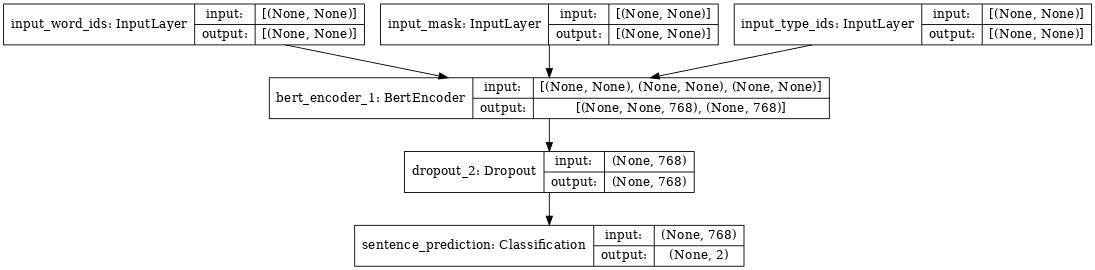

In [48]:
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=64)

In [49]:
try:
  tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=64)
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

AttributeError: 'KerasLayer' object has no attribute 'layers'


<a id="model_builder_functions"></a>

### Low level model building

If you need a more control over the construction of the model it's worth noting that the `classifier_model` function used earlier is really just a thin wrapper over the `nlp.modeling.networks.BertEncoder` and `nlp.modeling.models.BertClassifier` classes. Just remember that if you start modifying the architecture it may not be correct or possible to reload the pre-trained checkpoint so you'll need to retrain from scratch.

Build the encoder:

In [50]:
bert_encoder_config = config_dict.copy()

# You need to rename a few fields to make this work:
bert_encoder_config['attention_dropout_rate'] = bert_encoder_config.pop('attention_probs_dropout_prob')
bert_encoder_config['activation'] = tf_utils.get_activation(bert_encoder_config.pop('hidden_act'))
bert_encoder_config['dropout_rate'] = bert_encoder_config.pop('hidden_dropout_prob')
bert_encoder_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=bert_encoder_config.pop('initializer_range'))
bert_encoder_config['max_sequence_length'] = bert_encoder_config.pop('max_position_embeddings')
bert_encoder_config['num_layers'] = bert_encoder_config.pop('num_hidden_layers')

bert_encoder_config

{'hidden_size': 768,
 'intermediate_size': 3072,
 'num_attention_heads': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522,
 'attention_dropout_rate': 0.1,
 'activation': <function official.modeling.activations.gelu.gelu(x)>,
 'dropout_rate': 0.1,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7fe203c32d68>,
 'max_sequence_length': 512,
 'num_layers': 12}

In [51]:
manual_encoder = nlp.modeling.networks.BertEncoder(**bert_encoder_config)

Restore the weights:

In [52]:
checkpoint = tf.train.Checkpoint(encoder=manual_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Test run it:

In [53]:
result = manual_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 23, 768)
Pooled output shape: (2, 768)


Wrap it in a classifier:

In [54]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=bert_encoder_config['dropout_rate'],
        initializer=bert_encoder_config['initializer'])

In [55]:
manual_classifier(my_examples, training=True).numpy()

array([[ 0.1309041 , -0.20986415],
       [-0.09952673,  0.05040173]], dtype=float32)

<a id="optiizer_schedule"></a>

### Optimizers and schedules

The optimizer used to train the model was created using the `nlp.optimization.create_optimizer` function:

In [56]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

That high level wrapper sets up the learning rate schedules and the optimizer.

The base learning rate schedule used here is a linear decay to zero over the training run:

In [57]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs

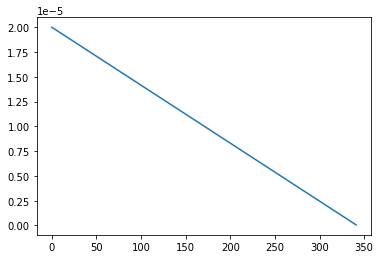

In [58]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

This, in turn is wrapped in a `WarmUp` schedule that linearly increases the learning rate to the target value over the first 10% of training:

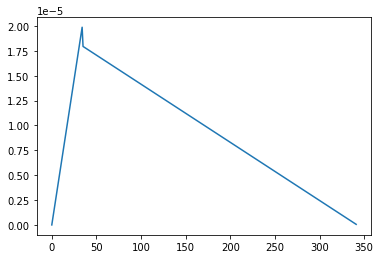

In [59]:
warmup_steps = num_train_steps * 0.1

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

# The warmup overshoots, because it warms up to the `initial_learning_rate`
# following the original implementation. You can set
# `initial_learning_rate=decay_schedule(warmup_steps)` if you don't like the
# overshoot.
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

Then create the `nlp.optimization.AdamWeightDecay` using that schedule, configured for the BERT model:

In [60]:
optimizer = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])